
# Maximal Representative Subsampling


<div class="alert alert- block alert-warning"> <b>Update:</b> 

- Mit aktuellem Algorithmus auf bereits repräsentativen US Census Daten starten.

- Census mitteln über mehrere Durchläufe.

- Gesis weiterlaufen.. auch nach 200 Instanzen.

- Allensbach Problem ??

- Nachdenken (Verhalten gegen Ende?).

</div>

In [1]:
from pathlib import Path
import os

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from scipy import stats

import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import numpy as np
np.seterr(divide = 'ignore')
import random

path = Path(os.getcwd()).parent

### Plots

In [2]:
def plot_results(score, n, title):

    labels = [s[0] for s in score]
    preds = [s[1] for s in score]

    ks = [stats.ks_2samp(l, p) for l,p in zip(labels, preds)]
    auc = [metrics.roc_auc_score(l, p) for l,p in zip(labels, preds)]

    dropped = [n[0]-i for i in n]
    plots(dropped, [k[0] for k in ks], "KS")
    plots(dropped, [k[1] for k in ks], "KS (p-value)")
    plots(dropped, auc, "AUC")
    plt.legend(loc='lower left')
    plt.title(title)
    plt.savefig(title+'.png')
    plt.show()

def plots(x, y, name):
    plt.plot(x, y, label=name)
    if(name == "AUC"):
        plt.plot(x, len(x)*[0.5], linestyle='--')
    plt.xlabel("removed instances")
    plt.grid()

## MRS ALGORITHM

In [38]:
def temp_sample(softmax, temperature, drop):

    EPSILON = 10e-16 # to avoid taking the log of zero
    softmax = (np.array(softmax) + EPSILON).astype('float64')
    
    preds = np.log(softmax) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(drop, preds, 1)

    return probas[0]

def bootstrap(n_samples, size):
    bootstrap = []
    for _ in range(size):
        bootstrap.append(random.randint(0,n_samples-1))
    return bootstrap

def MRS(data, columns, temperature, n_drop = 20, limit = 50, 
        ensemble_size = 5, baseline = False):
    
    data_base = data.copy(deep=True)
    data = data_base.copy(deep=True)

    global score
    global n
    global imp

    while (len(data[data.label == 1]) > limit):
        
        nonrep = data[data.label == 1].copy(deep=True)
        rep = data[data.label == 0].copy(deep=True)
        
        data = pd.concat([nonrep, rep], sort=True).copy(deep=True)
        
        b_size = nonrep.shape[0] #bootstrap size: number of nonrep. samples 
        
        preds = [[] for i in range(data.shape[0])]

        for _ in range(ensemble_size):

            b1 = bootstrap(b_size, b_size)
            b0 = bootstrap(rep.shape[0], b_size)
            
            train = pd.concat([nonrep.iloc[b1], rep.iloc[b0]], sort=False)
            
            sub = train.drop_duplicates(keep = 'first', inplace = False).copy(deep=True)
            test = data[~data.isin(sub)].dropna()
            
            dt = DecisionTreeClassifier()
            depths = np.array([5, 10, 30, 50])
            grid = GridSearchCV(cv=3, estimator=dt, iid=True,
                                param_grid=dict(min_samples_leaf=depths))
            grid.fit(train[columns], train.label)
            
            dt = DecisionTreeClassifier(max_depth=grid.best_estimator_.min_samples_leaf)
            dt.fit(train[columns], train.label)
            
            imp = [i + f for i,f in zip(imp, dt.feature_importances_)]
            
            if test[columns].shape[0]==0:
                break;
            prob = [p[1] for p in dt.predict_proba(test[columns])]
            
            for i in range(len(prob)):
                preds[test.index[i]].append(prob[i])
        
        for r in range(len(preds)):
            if len(preds[r]) == 0:
                preds[r] = 0
            else:
                preds[r] = np.mean(preds[r]) 
        
        score.append((data.label, preds))
        n.append(len(data.index))

        print(len(data.index), end=', ')

        if baseline == True: 
            preds = [random.random() for _ in preds]

        data['removed'] = temp_sample(preds, temperature, n_drop)
        data = data[(data.removed == 0) | (data.label==0)]
        data.drop('removed', axis=1, inplace=True) #inplace?

        data.reset_index(drop=True, inplace=True)

### US National Census (Income) <a name="us"></a>

*About this Dataset*

**US Adult Census** (1994) relates income to social factors: 

- *age*: continuous.
- *workclass*: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- *fnlwgt*: continuous.
- *education*: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- *education-num*: continuous.
- *marital-status*: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- *occupation*: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- *relationship*: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- *race*: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- *sex*: Female, Male.
- *capital-gain*: continuous.
- *capital-loss*: continuous.
- *hours-per-week*: continuous.
- *native-country*: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Each row is labelled as either having a salary greater than ">50K" or "<=50K".

Note: This Dataset was obtained from the UCI repository, it can be found on

https://archive.ics.uci.edu/ml/datasets/census+income, http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/

In [24]:
columns = ['Age','Workclass','fnlgwt','Education','Education Num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Country','Above/Below 50K']

train = pd.read_csv(os.path.join(path, 'data/census_income/adult.data'), names=columns)
test = pd.read_csv(os.path.join(path, 'data/census_income/adult.test'), names=columns)
test = test.iloc[1:]

df = pd.concat([train, test]).copy(deep=True)

del train, test

df.replace(' >50K.', ' >50K', inplace=True)
df.replace(' <=50K.', ' <=50K', inplace=True)

df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

ctg = ['Workclass', 'Sex', 'Education', 'Marital Status', 
       'Occupation', 'Relationship', 'Race', 'Country']
for c in ctg:
    df = pd.concat([df, pd.get_dummies(df[c], 
                                       prefix=c,
                                       dummy_na=False)], axis=1).drop([c],axis=1)

'''Rep: <=50K    37155 ;; >50K     11687'''

df_high = df[df['Above/Below 50K'] == " >50K"].copy(deep=True)
df_low = df[df['Above/Below 50K'] == " <=50K"].copy(deep=True)

df_low = df_low.reindex(np.random.permutation(df_low.index))
df_high = df_high.reindex(np.random.permutation(df_high.index))

rep = pd.concat([df_low.head(10000).copy(deep=True),
                 df_high.head(2000).copy(deep=True)], sort=True)

nonrep = pd.concat([df_low.tail(5000).copy(deep=True),
                    df_high.tail(11000).copy(deep=True)], sort=True)

print('Rep: \n', rep['Above/Below 50K'].value_counts(), '\n')
print('Nonrep: \n', nonrep['Above/Below 50K'].value_counts())

nonrep['label'] = 1
rep['label'] = 0

del df, df_low, df_high

us = pd.concat([nonrep, rep], sort=True)

us_columns = list(us.columns)
meta = ['label', 'Above/Below 50K', 'index', 'bootstrap']
for m in meta:
    if m in us_columns:
        us_columns.remove(m)

us.reset_index(drop=True, inplace=True)
us.head()

Rep: 
  <=50K    10000
 >50K      2000
Name: Above/Below 50K, dtype: int64 

Nonrep: 
  >50K     11000
 <=50K     5000
Name: Above/Below 50K, dtype: int64


,Above/Below 50K,Age,Capital Gain,Capital Loss,Country_ ?,Country_ Cambodia,Country_ Canada,Country_ China,Country_ Columbia,Country_ Cuba,...,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay,fnlgwt,label
0,<=50K,46,0.0,0.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,354962.0,1
1,<=50K,22,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,110622.0,1
2,<=50K,70,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,177199.0,1
3,<=50K,35,5013.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,114087.0,1
4,<=50K,30,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,101859.0,1


In [ ]:
allensbach = pd.read_csv(os.path.join(path, 'data/allensbach_mrs.csv'))

allensbach.drop(['Unnamed: 0'], axis=1, inplace=True)

allensbach_columns = ['BRS1', 'BRS2', 'BRS3', 'BRS4', 'BRS5', 'BRS6', 
                      'Berufsgruppe', 'Erwerbstätigkeit', 'Geschlecht',
                      'Optimismus', 'Pessimismus', 'Schulabschluss', 'woechentlicheArbeitszeit']
allensbach.head()

In [29]:
gbs_p = pd.read_csv(os.path.join(path, 'data/gbs_processed.csv'), engine='python')
gesis_p = pd.read_csv(os.path.join(path, 'data/gesis_processed.csv'), engine='python')

gesis_p['label'] = 0
gbs_p['label'] = 1

gesis_columns = ['Geschlecht', 'Aktiv', 'Berufsgruppe', 'Schlechter Schlaf', 'Leben genießen',
       'Zu Nichts aufraffen', 'Alles anstrengend', 'Wahlteilnahme',
       'Wach', 'Zurueckhaltend', 'Resilienz', 'Zufriedenheit Wahlergebnis',
       'leicht Vertrauen', 'Faulheit', 'Entspannt',
       'wenig kuenstlerisches Interesse', 'Gesellig']

''' 'Andere kritisieren', 'Geburtsland', 'Geburtsjahr',,
       'Personen im Haushalt', 'Nettoeinkommen Selbst',
       'Nettoeinkommen Haushalt', 'Schlechter Schlaf', 'Leben genießen',
       'Zu Nichts aufraffen', 'Alles anstrengend', 'Wahlteilnahme',
       'Wahlabsicht', 'Desinteresse Politiker'
       'Nationalitaet', 'Familienstand', 'Hoechster Bildungsabschluss',
       'Berufliche Ausbildung', 'Erwerbstaetigkeit', 
       'Gruendlich', 'Nervoes', 'Phantasievoll', 'Optimismus Zukunft'''

gesis = pd.concat([gesis_p.copy(deep=True), gbs_p.copy(deep=True)], sort=True)
gesis.reset_index(drop=True, inplace=True)
gesis.fillna(gesis.median(), inplace=True)
gesis.head()

,Aktiv,Alles anstrengend,Andere kritisieren,Berufliche Ausbildung,Berufsgruppe,Desinteresse Politiker,Druck,Entspannt,Erwerbstaetigkeit,Familienstand,...,Wahlabsicht,Wahlteilnahme,Zu Nichts aufraffen,Zufriedenheit Leben,Zufriedenheit Wahlergebnis,Zurueckhaltend,label,leicht Vertrauen,wenig kuenstlerisches Interesse,Ängstlich
0,4.0,2.000000,3.000000,5.000000,0.792997,3.0,5.0,3.000000,2.0,1.0,...,1.0,1.0,1.000000,9.0,4.000000,3.000000,0,3.000000,4.000000,1.0
1,3.0,2.000000,3.000000,1.000000,0.000000,2.0,8.0,1.000000,1.0,1.0,...,0.0,0.0,3.000000,3.0,3.031949,5.000000,0,5.000000,5.000000,2.0
2,4.0,4.000000,2.943358,2.924228,0.792997,3.0,5.0,2.989853,2.0,2.0,...,1.0,0.0,3.000000,7.0,3.031949,2.965447,0,3.181888,2.882487,2.0
3,3.0,1.000000,3.000000,2.000000,0.000000,2.0,8.0,2.000000,1.0,1.0,...,1.0,1.0,1.000000,8.0,3.000000,4.000000,0,4.000000,2.000000,1.0
4,3.0,2.726568,4.000000,1.000000,0.000000,3.0,5.0,2.000000,1.0,2.0,...,1.0,1.0,2.303794,3.0,3.000000,5.000000,0,4.000000,4.000000,1.0


In [44]:
score = []
n = []
imp = [0 for _ in range(len(gesis_columns))]

MRS(data=gesis, columns=gesis_columns, temperature=0.6, n_drop=20, limit=50)

4828, 4828, 4808, 4789, 4769, 4749, 4731, 4713, 4695, 4676, 4657, 4638, 4619, 4603, 4583, 4565, 4551, 4543, 4535, 4534, 4533, 4532, 4531, 4529, 4528, 4527, 4526, 4524, 4524, 4522, 4521, 4520, 4520, 4520, 4519, 4518, 4515, 4514, 4513, 4513, 4513, 4512, 4511, 4510, 4510, 4508, 4508, 4505, 4505, 4502, 4501, 4498, 4497, 4497, 4496, 4494, 4493, 4492, 4490, 4489, 4489, 4489, 4489, 4487, 4485, 4484, 4483, 4483, 4483, 4483, 4482, 4480, 4480, 4478, 4478, 4477, 4476, 4474, 4471, 4470, 4469, 4468, 4464, 4462, 4461, 4460, 4460, 4459, 4459, 4459, 4458, 4458, 4458, 4457, 4455, 4454, 4454, 4454, 4453, 4453, 4452, 4452, 4452, 4450, 4450, 4450, 4447, 4447, 4447, 4447, 4447, 4447, 4446, 4446, 4444, 4442, 4442, 4441, 4441, 4441, 4440, 4438, 4436, 4435, 4433, 4433, 4432, 4432, 4432, 4431, 4429, 4428, 4426, 4423, 4422, 4422, 4421, 4420, 4420, 4420, 4419, 4418, 4417, 4417, 4416, 4414, 4410, 4410, 4409, 4407, 4406, 4404, 4403, 4403, 4402, 4400, 4400, 4400, 4399, 4398, 4398, 4398, 4397, 4397, 4397, 4396, 4396

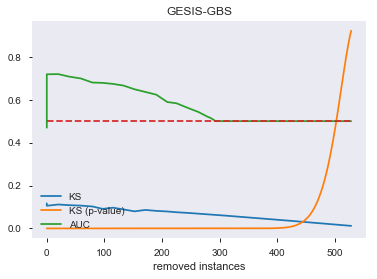

In [45]:
plot_results(score, n, 'GESIS-GBS')

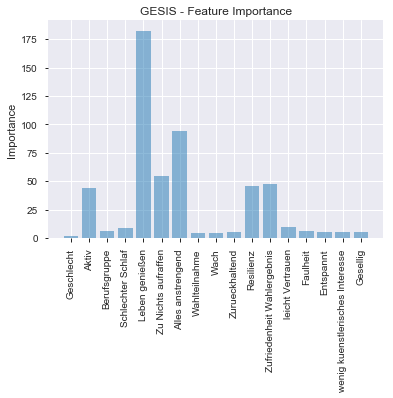

In [46]:
y_pos = np.arange(len(gesis_columns))

plt.bar(y_pos, imp, align='center', alpha=0.5)
plt.xticks(y_pos, gesis_columns, rotation=90)
plt.ylabel('Importance')
plt.title('GESIS - Feature Importance')
plt.show()

In [6]:
score = []
n = []
imp = [0 for _ in range(len(us_columns))]

MRS(data=us, columns=us_columns, temperature=0.2, n_drop=500, limit=1000, ensemble_size=5)

20000, 19760, 19497, 19272, 19042, 18814, 18592, 18369, 18142, 17930, 17727, 17506, 17291, 17077, 16876, 16696, 16492, 16315, 16139, 15969, 15834, 15665, 15487, 15296, 15133, 14977, 14819, 14673, 14529, 14367, 14208, 14093, 13970, 13843, 13729, 13608, 13497, 13370, 13262, 13146, 13046, 12934, 12835, 12739, 12645, 12563, 12471, 12368, 12278, 12200, 12124, 12034, 11946, 11878, 11782, 11716, 11648, 11576, 11513, 11440, 11383, 11337, 11278, 11228, 11155, 11103, 11048, 11001, 

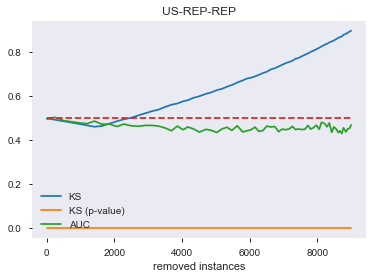

In [7]:
plot_results(score, n, 'US-REP-REP')

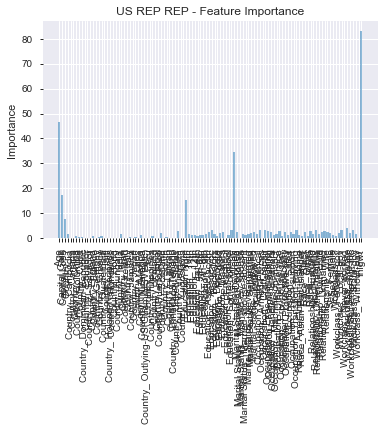

In [9]:
y_pos = np.arange(len(us_columns))

plt.bar(y_pos, imp, align='center', alpha=0.5)
plt.xticks(y_pos, us_columns, rotation=90)
plt.ylabel('Importance')
plt.title('US REP REP - Feature Importance')
plt.show()

28000, 26629, 25341, 24148, 23051, 22075, 21215, 20424, 19687, 19021, 18417, 17863, 17382, 16942, 16546, 16165, 15835, 15518, 15215, 14965, 14729, 14490, 14288, 14087, 

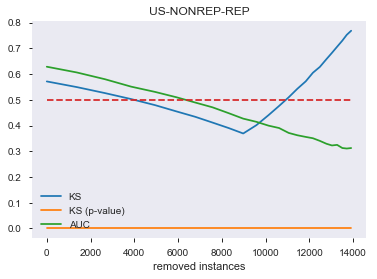

28000, 26647, 25375, 24200, 23127, 22108, 21212, 20402, 19652, 19000, 18397, 17851, 17344, 16890, 16469, 16117, 15768, 15472, 15180, 14916, 14659, 14444, 14216, 14023, 

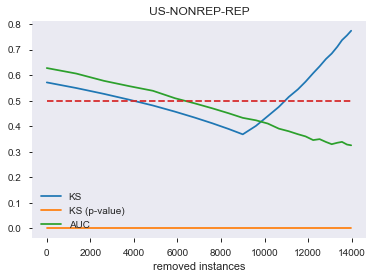

28000, 26645, 25410, 24309, 23226, 22226, 21323, 20528, 19790, 19100, 18456, 17883, 17388, 16930, 16507, 16129, 15746, 15425, 15116, 14859, 14622, 14410, 14214, 14025, 

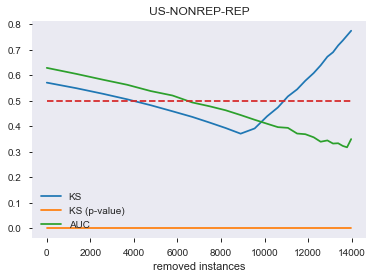

28000, 26689, 25441, 24302, 23235, 22239, 21298, 20500, 19742, 19052, 18428, 17861, 17356, 16871, 16454, 16084, 15758, 15404, 15143, 14881, 14623, 14407, 14211, 14009, 

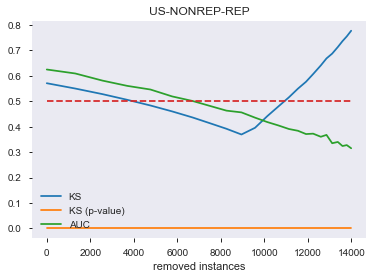

28000, 26667, 25471, 24303, 23267, 22297, 21402, 20569, 19864, 19149, 18526, 17945, 17427, 16937, 16484, 16100, 15763, 15432, 15124, 14829, 14562, 14337, 14143, 

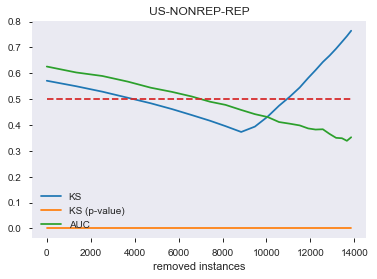

In [25]:
#5 fach gemittelt:

for t in range(5):

    score = []
    n = []
    imp = [0 for _ in range(len(us_columns))]

    MRS(data=us, columns=us_columns, temperature=0.3+0.1*t, n_drop=2000, limit=2000, ensemble_size=2)

    plot_results(score, n, 'US-NONREP-REP')